This code generates timestream template for AFG1022/AFT1062 that gives frequency comb for calibration, mostly following Gadi's legacy Matlab code.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from scipy.fft import fft, fftfreq, fftshift
from scipy.signal import welch

In [2]:
def get_signal(tt, ff, phase=None):
    sig = np.zeros_like(tt)
    if phase is None:
        phase = np.zeros_like(ff)

    for i, f in enumerate(ff):
            sig += np.sin(2 * np.pi * f * tt + phase[i])
            
    return sig

def get_ff(ff_want, ff_samp):
    ff = np.zeros_like(ff_want)
    for i, f_want in enumerate(ff_want):
          ff[i] = ff_samp[np.argmin(np.abs(ff_samp - f_want))]
    return ff

In [11]:
# `rep_rate` * `nsample` has to be roughly larger than 100 kHz
# to exceed nyquist frequency of frequency range we're working with
# AFG1022 has max samping rate of 125 MHz

# rep_rate = 100
# nsample = 8000
rep_rate = 100
nsample = 1000000

fstart, fend = 50000, 100000
delta_f = 10000
ff_want = np.arange(fstart, fend+delta_f, delta_f)

In [12]:
tt = np.linspace(0, 1 / rep_rate, nsample)
delta_t = tt[1] - tt[0]

# FFT sample frequcies based on our choice of time resolution
ff_samp = fftfreq(nsample, delta_t)

In [13]:
# Select the frequencies in the range of interest
# We use only positive frequencies because these will
# be fed to a sine signal which has both positive and negative
# frequencies
# ff = ff_samp[np.logical_and(ff_samp > fstart, ff_samp < fend)]

ff = get_ff(ff_want, ff_samp)
print('Sample frequencies:', ff)

Sample frequencies: [39995 41994 43994 45994 47994 49993 51993 53993 55993 57992 59992 61992
 63992 65991 67991 69991 71991 73990 75990 77990 79990 81989 83989 85989
 87989 89988]


In [14]:
# Now try to optimize phase configuration
# Do Monte Carlo to find th phase that gives 
# maximally uniform magnitude in the time domain
n_iter = 1000
sums = np.zeros(n_iter)
phases = np.zeros((n_iter, ff.size))

for i in range(n_iter):
    np.random.seed(i)

    phase = np.random.rand(ff.size) * 2 * np.pi
    sig = get_signal(tt, ff, phase)
    
    sums[i] = np.max(np.abs(sig))
    phases[i] = phase
    
best_phase = phases[np.argmin(sums)]

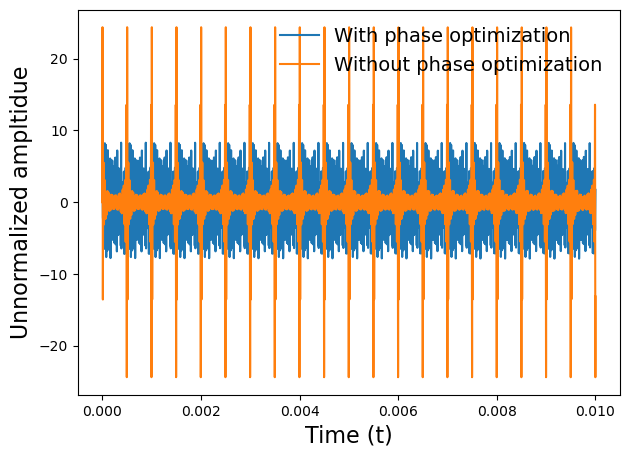

In [15]:
sig = get_signal(tt, ff, best_phase)
bad_sig = get_signal(tt, ff, None)

fig, ax = plt.subplots(figsize=(7, 5))
ax.plot(tt, sig, label='With phase optimization')
ax.plot(tt, bad_sig, label='Without phase optimization')

ax.set_xlabel('Time (t)', fontsize=16)
ax.set_ylabel('Unnormalized ampltidue', fontsize=16)
ax.legend(frameon=False, fontsize=14)

Now plot the FFT magnitude of the signal - should see a flat band in our frequency range

(35000.0, 95000.0)

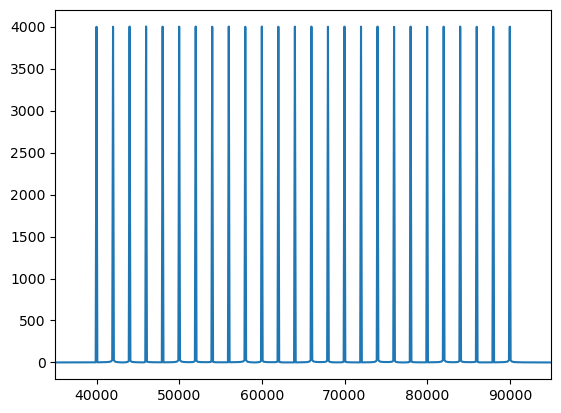

In [16]:
sp = fftshift(fft(sig))
freq = fftshift(fftfreq(tt.size, delta_t))

plt.plot(freq, np.abs(sp))
plt.xlim(fstart-5000, fend + 5000)

Can also estimate the signal PSD - I think ideally we want to repeat the measurement using many different phase configurations and average over them.

(35000.0, 95000.0)

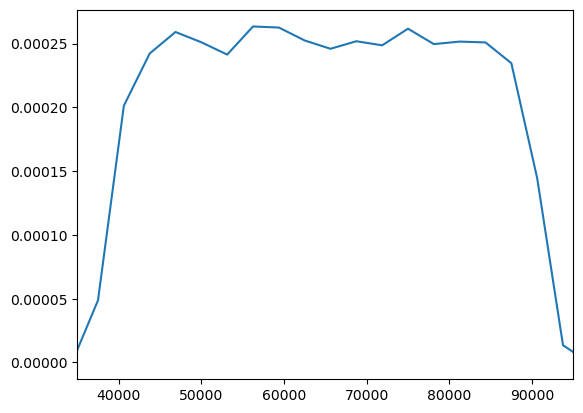

In [17]:
f, pxx = welch(sig, rep_rate*nsample)
plt.plot(f, pxx)

plt.xlim(fstart-5000, fend + 5000)

In [18]:
file_name = 'freq_comb_40khz_90khz_deltaf2khz.npz'
np.savez(file_name, sig=sig, tt=tt, ff=ff)

In [63]:
ff

array([19997, 21997, 23997, 25996, 27996, 29996, 31996, 33995, 35995,
       37995, 39995, 41994, 43994, 45994, 47994, 49993, 51993, 53993,
       55993, 57992, 59992, 61992, 63992, 65991, 67991, 69991])